In [35]:
from PIL import Image
import os
import time
import numpy as np
import matplotlib.pyplot as plt

In [36]:
directory = "motorbike"

image_list = []
for filename in os.listdir(directory):
    if filename.endswith(".jpg") or filename.endswith(".png"):
        img = Image.open(os.path.join(directory, filename))
        image_list.append(img)

In [37]:
new_size = (256, 256)  # Example size
resized_images = [img.resize(new_size) for img in image_list]

In [38]:
numpy_images = [np.array(img) for img in resized_images]

In [39]:
numpy_images[0].shape

(256, 256, 3)

In [40]:
# s-box generated using chaotic map and heuristic method
s_box = [
    [110, 68, 222, 159, 44, 19, 51, 121, 179, 106, 83, 187, 157, 228, 152, 62],
    [254, 240, 130, 97, 117, 173, 170, 213, 31, 84, 96, 239, 52, 1, 47, 245],
    [234, 225, 164, 58, 137, 95, 178, 14, 4, 42, 252, 140, 177, 66, 10, 53],
    [35, 101, 186, 12, 145, 126, 184, 141, 189, 206, 112, 156, 99, 75, 196, 63],
    [236, 251, 30, 135, 114, 102, 199, 67, 120, 88, 241, 15, 94, 233, 182, 122],
    [244, 127, 70, 18, 93, 20, 133, 131, 40, 255, 180, 124, 27, 8, 9, 72],
    [7, 26, 230, 146, 32, 129, 0, 183, 214, 235, 205, 215, 16, 246, 60, 242],
    [204, 33, 41, 202, 107, 142, 203, 210, 50, 223, 13, 79, 2, 221, 163, 98],
    [162, 188, 212, 108, 118, 168, 227, 195, 175, 38, 86, 174, 218, 190, 200, 24],
    [191, 207, 73, 172, 100, 87, 105, 103, 217, 149, 11, 229, 111, 226, 69, 211],
    [243, 23, 85, 28, 136, 109, 55, 161, 119, 198, 45, 56, 74, 160, 36, 39],
    [158, 6, 253, 64, 169, 139, 238, 21, 150, 144, 61, 81, 22, 181, 249, 104],
    [155, 209, 194, 138, 125, 167, 71, 176, 116, 232, 89, 237, 29, 151, 80, 247],
    [219, 48, 43, 208, 193, 147, 49, 224, 128, 46, 143, 216, 3, 197, 65, 113],
    [92, 115, 231, 76, 82, 192, 59, 248, 5, 220, 201, 25, 132, 17, 134, 250],
    [154, 148, 166, 91, 78, 57, 34, 185, 123, 54, 153, 165, 77, 90, 171, 37]
]
S_box = np.array(s_box)

In [41]:
def scrambling_img(img_arr):
    
    # 2) dividing the image into red, green and blue channels
    red = img_arr[:, : , 0:1]
    green = img_arr[:, : , 1:2]
    blue = img_arr[:, :, 2:3]
    
    red1 = np.empty((256, 256, 1), dtype=object)
    green1 = np.empty((256, 256, 1), dtype=object)
    blue1 = np.empty((256, 256, 1), dtype=object)
    
    for i in range(256):
        for j in range(256):
            red1[i][j][0] = format(red[i][j][0], '08b')
            green1[i][j][0] = format(green[i][j][0], '08b')
            blue1[i][j][0] = format(blue[i][j][0], '08b')
    # Combining bits for each channel
    combined_matrix = np.concatenate((red1, green1, blue1), axis=2)
    combined_matrix = combined_matrix.reshape(-1)
    #Separate the vector into small vectors of size 16 bits
    new_combined_matrix = np.array([combined_matrix[i] + combined_matrix[i + 1] for i in range(0, len(combined_matrix), 2)])
    new_mat = new_combined_matrix
    new_mat = replace_bits(new_mat)
    binary_array_8_bit = split_16bit_to_8bit(new_mat)
    new_lst = list()
    for str in binary_array_8_bit:
        integer_value = int(str, 2)
        new_lst.append(integer_value)
    original_vector = np.array(new_lst)
    reshaped_array = original_vector.reshape(768, 256)
    
    final_lst = list()
    for arr in reshaped_array:
        lst = list()
        output_array = S_box[arr // 16, arr % 16]
        lst = output_array.tolist()
        final_lst.append(lst)
    final_array = np.array(final_lst)
    final_arr = final_array.reshape(256, 256, 3)
    return final_arr

In [42]:
def replace_bits(arr):
    for i in range(len(arr)):
        # Convert binary string to a list of characters
        binary_list = list(arr[i])
        
        # Replace 1 to 4 bits with last 4 bits
        binary_list[:4] = binary_list[-4:]
        
        # Convert list back to a string and update the array
        arr[i] = ''.join(binary_list)
    return arr   

In [43]:
# code to split 16 bit strings into 8 bit
def split_16bit_to_8bit(arr):
    new_array = []
    for string in arr:
        # Split each 16-bit string into two 8-bit strings
        eight_bit_strings = [string[i:i+8] for i in range(0, len(string), 8)]
        
        # Extend the new array with the 8-bit strings
        new_array.extend(eight_bit_strings)
    
    return np.array(new_array)

In [44]:
hyper_key = np.zeros((256, 256, 3), dtype=np.uint8)
def encryption(final_arr):
    X = [0.1]  # Initial value for logistic map
    C = 3.9999
    henon_a = 1.76
    henon_b = 0.1
    # Generate Logistic Map sequence
    for i in range(1, 257 * 256):
        X.append(logistic_map(X[i - 1], C))
    # Initialize HyperLogVarHénon matrix
    HyperLogVarHénon = np.zeros((256, 256, 3), dtype=np.uint8)
    for i in range(256):
        for j in range(256):
            idx = i * 256 + j
            if idx % 2 == 0:  # Even position
            
                x_next = henon_a - X[idx] ** 2 - henon_b * X[idx + 1]
                y_next = X[idx]
                z_next = X[idx + 1]
            else:  # Odd position
                x_next = X[idx]
                y_next = X[idx]
                z_next = X[idx + 1]
        # Scale and round the values to convert to unsigned integers
            x_next = round(x_next * 255)
            y_next = round(y_next * 255)
            z_next = round(z_next * 255)

        # Ensure the values are within the 0-255 range
            x_next = min(max(x_next, 0), 255)
            y_next = min(max(y_next, 0), 255)
            z_next = min(max(z_next, 0), 255)

        # Store values as unsigned integers in the matrix
            HyperLogVarHénon[i, j] = [x_next, y_next, z_next]
    
    hyper_key = HyperLogVarHénon
    # Divide the HyperLogVarHénon map matrix into three matrices with a length of 256 × 256 values so that there is a key matrix for the red, green and blue channels.
    red_key = hyper_key[:, : , 0:1] 
    green_key = hyper_key[:, : , 1:2]
    blue_key = hyper_key[:, :, 2:3]
    
    red_arr = final_arr[:, : , 0:1]
    green_arr = final_arr[:, : , 1:2]
    blue_arr = final_arr[:, :, 2:3]
    
    result1 = np.bitwise_xor(red_arr, red_key)
    result2 = np.bitwise_xor(green_arr, green_key)
    result3 = np.bitwise_xor(blue_arr, blue_key)
    
    result = np.concatenate((result1, result2, result3), axis=2)
    
    encrypted_image = Image.fromarray(np.uint8(result))
    return result

In [45]:
def logistic_map(x, c):
    return c * x * (1 - x)

In [48]:
time1 = time.time()
res1 = scrambling_img(numpy_images[0])
res = encryption(res1)

time2 = time.time()
analysis(res, numpy_images[0])
print(time2-time1)

Information Entropy: 7.8312907335988715
NPCR: 99.64%
uaci 0.39478596207363154
the mean squared error is  15147.577412923178
0.7538483142852783


In [47]:
 def analysis(result, img_arr):
        
        # information Entropy
        flat_array = result.flatten()

        # Calculate the frequency of each unique value
        value, counts = np.unique(flat_array, return_counts=True)

        # Calculate probabilities
        probabilities = counts / len(flat_array)

        # Calculate information entropy
        entropy = -np.sum(probabilities * np.log2(probabilities))

        print("Information Entropy:", entropy)
        pixel_difference = np.sum(img_arr != result)

        # Calculate total pixels (total elements in one image matrix)
        total_pixels = np.prod(img_arr.shape)

        # Calculate NPCR
        npcr = (pixel_difference / total_pixels) * 100

        print(f"NPCR: {npcr:.2f}%")
        
        # calculate UACI
        total_pixels = img_arr.size

    # Calculate the absolute difference in intensity between matrices
        abs_diff = np.abs(img_arr - result)

    # Calculate the total sum of absolute differences (TSAD)
        tsad = np.sum(abs_diff)

    # Normalize the TSAD and calculate the UACI value
        uaci = tsad / (255 * total_pixels)
        print("uaci", uaci)
        
        print("the mean squared error is ", mse(img_arr, result))

In [65]:
def graphical_analysis(result, img_arr):
    plot_histogram_red(result)
    plot_histogram_green(result)
    plot_histogram_blue(result)


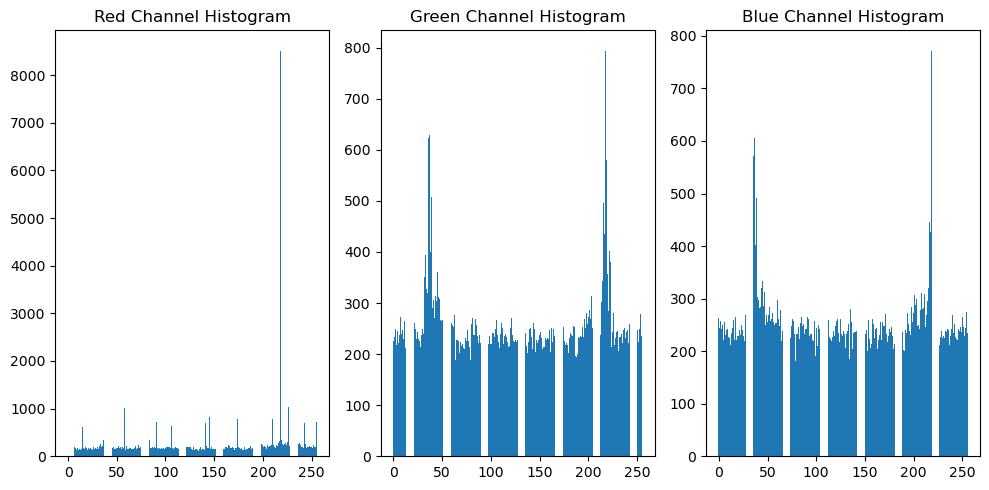

In [17]:
import numpy as np
import matplotlib.pyplot as plt

# Assuming you have your encrypted image matrix as encrypted_image (256x256x3)
# Replace this with your actual encrypted image matrix

# Generate a random 256x256x3 matrix as an example
#encrypted_image = np.random.randint(0, 256, size=(256, 256, 3), dtype=np.uint8)

# Separate color channels (R, G, B)
red_channel = res[:, :, 0]
green_channel = res[:, :, 1]
blue_channel = res[:, :, 2]

# Calculate histograms for each color channel
red_hist = np.histogram(red_channel, bins=256, range=(0, 256))
green_hist = np.histogram(green_channel, bins=256, range=(0, 256))
blue_hist = np.histogram(blue_channel, bins=256, range=(0, 256))

# Plot histograms
plt.figure(figsize=(10, 5))

plt.subplot(131)
plt.title('Red Channel Histogram')
plt.bar(np.arange(256), red_hist[0])

plt.subplot(132)
plt.title('Green Channel Histogram')
plt.bar(np.arange(256), green_hist[0])

plt.subplot(133)
plt.title('Blue Channel Histogram')
plt.bar(np.arange(256), blue_hist[0])

plt.tight_layout()
plt.show()



In [34]:
def mse(original_array, encrypted_array):
    # Calculate squared difference
    diff = original_array - encrypted_array
    squared_diff = diff ** 2
    
    # Calculate MSE
    mse_value = np.mean(squared_diff)
    return mse_value

In [ ]:
def decryption(result)